Data Source: https://www.kaggle.com/datasets/goyaladi/fraud-detection-dataset/data

In [81]:
import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance

## 1. Import the data

Since the data files are stored in different sub-directories, I will store data in the form of dictionary, with key representing the filename and values containing data from the corresponding file.

In [82]:
data_dir = ".\\Data\\*\\*.csv"
data_path = glob.glob(data_dir, recursive=True)
data = {}

for file in data_path:
    filename = os.path.basename(file)[:-4]
    df = pd.read_csv(file, header=0)
    data.update({filename: df})

data.keys()

dict_keys(['account_activity', 'customer_data', 'fraud_indicators', 'suspicious_activity', 'merchant_data', 'transaction_category_labels', 'amount_data', 'anomaly_scores', 'transaction_metadata', 'transaction_records'])

## 2. Exploratory Data Analysis

**Transaction Data**
- transaction_records.csv: Contains transaction records with details such as transaction ID, date, amount, and customer ID. It contains 1000 transactions
- transaction_metadata.csv: Contains additional metadata for each transaction.


**Customer Profiles**
- customer_data.csv: Includes customer profiles with information such as name, age, address, and contact details. It contains 2000 customers
- account_activity.csv: Provides details of customer account activity, including account balance, last login date.


**Fraudulent Patterns**
- fraud_indicators.csv: Contains indicators of fraudulent patterns and suspicious activities.
- suspicious_activity.csv: Provides specific details of transactions flagged as suspicious.


**Transaction Amounts**
- amount_data.csv: Includes transaction amounts for each transaction.
- anomaly_scores.csv: Provides anomaly scores for transaction amounts, indicating potential fraudulence.


**Merchant Information**
- merchant_data.csv: Contains information about merchants involved in transactions.
- transaction_category_labels.csv: Provides category labels for different transaction types.

Firstly, let's combine each dataframe into one for exploration.

In [83]:
# Transaction data
transaction = pd.merge(left=data['transaction_records'], right = data['transaction_metadata'], how = 'left', on='TransactionID')
transaction = pd.merge(left=transaction, right = data['anomaly_scores'], how = 'left', on='TransactionID')
transaction = pd.merge(left=transaction, right = data['amount_data'], how = 'left', on='TransactionID')
transaction = pd.merge(left=transaction, right = data['fraud_indicators'], how = 'left', on='TransactionID')
transaction = pd.merge(left=transaction, right = data['transaction_category_labels'], how = 'left', on='TransactionID')
transaction = pd.merge(left=transaction, right = data['merchant_data'], how = 'left', on='MerchantID')

# Customer Profiles
customer = pd.merge(left=data['customer_data'], right=data['account_activity'], on = "CustomerID" )
customer = pd.merge(left=customer, right=data['suspicious_activity'], on = "CustomerID" )

# Combine both
df = pd.merge(left=transaction, right=customer, how = "left", on = "CustomerID")
df.head(5)

# Delete the unnecessary variables to save memory
del transaction
del customer
del data
del data_dir
del data_path
del file
del filename

### Check for missing values and data type

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TransactionID      1000 non-null   int64  
 1   Amount             1000 non-null   float64
 2   CustomerID         1000 non-null   int64  
 3   Timestamp          1000 non-null   object 
 4   MerchantID         1000 non-null   int64  
 5   AnomalyScore       1000 non-null   float64
 6   TransactionAmount  1000 non-null   float64
 7   FraudIndicator     1000 non-null   int64  
 8   Category           1000 non-null   object 
 9   MerchantName       1000 non-null   object 
 10  Location           1000 non-null   object 
 11  Name               1000 non-null   object 
 12  Age                1000 non-null   int64  
 13  Address            1000 non-null   object 
 14  AccountBalance     1000 non-null   float64
 15  LastLogin          1000 non-null   object 
 16  SuspiciousFlag     1000 n

#### Check for duplicated records

In [85]:
df.duplicated().value_counts()

False    1000
Name: count, dtype: int64

It doesn't seem to have no duplicated records in the data.

#### Check for data imbalance
Given that our objective is to predict whether a transaction is fraud or not, we need to examine the proportion of our target variable (i.e., FraudIndicator) in our data.

In [86]:
df['FraudIndicator'].value_counts()

FraudIndicator
0    955
1     45
Name: count, dtype: int64

It appears that only 4.5% of the transactions are classified as fraudulent, which suggests that the data is highly imbalanced.

#### Check for effectiveness of suspicious flag

In [87]:
df.groupby('FraudIndicator')['SuspiciousFlag'].value_counts()

FraudIndicator  SuspiciousFlag
0               0                 933
                1                  22
1               0                  42
                1                   3
Name: count, dtype: int64

Based on the above, there is 45 fraud transactions, whilst only 3 transactions (i.e., 6.67%) has a suspicious flag. In addition, 22 normal transactions have a suspicious flag. This suggests that the suspicious flag may not be a perfect indicator of fraud and that there could be additional factors or features that contribute to the accurate indentification of fraudulent transaction. Also, it might be worth revising the mechanism of how the system detect suspicious activities as it does not seem to be effective at the moment.

### Data visualization

In order to get a preliminary idea on how fraudulent transaction may differ from normal transaction, it may be helpful to plot our target variable ("FraudIndicator") against other variables.

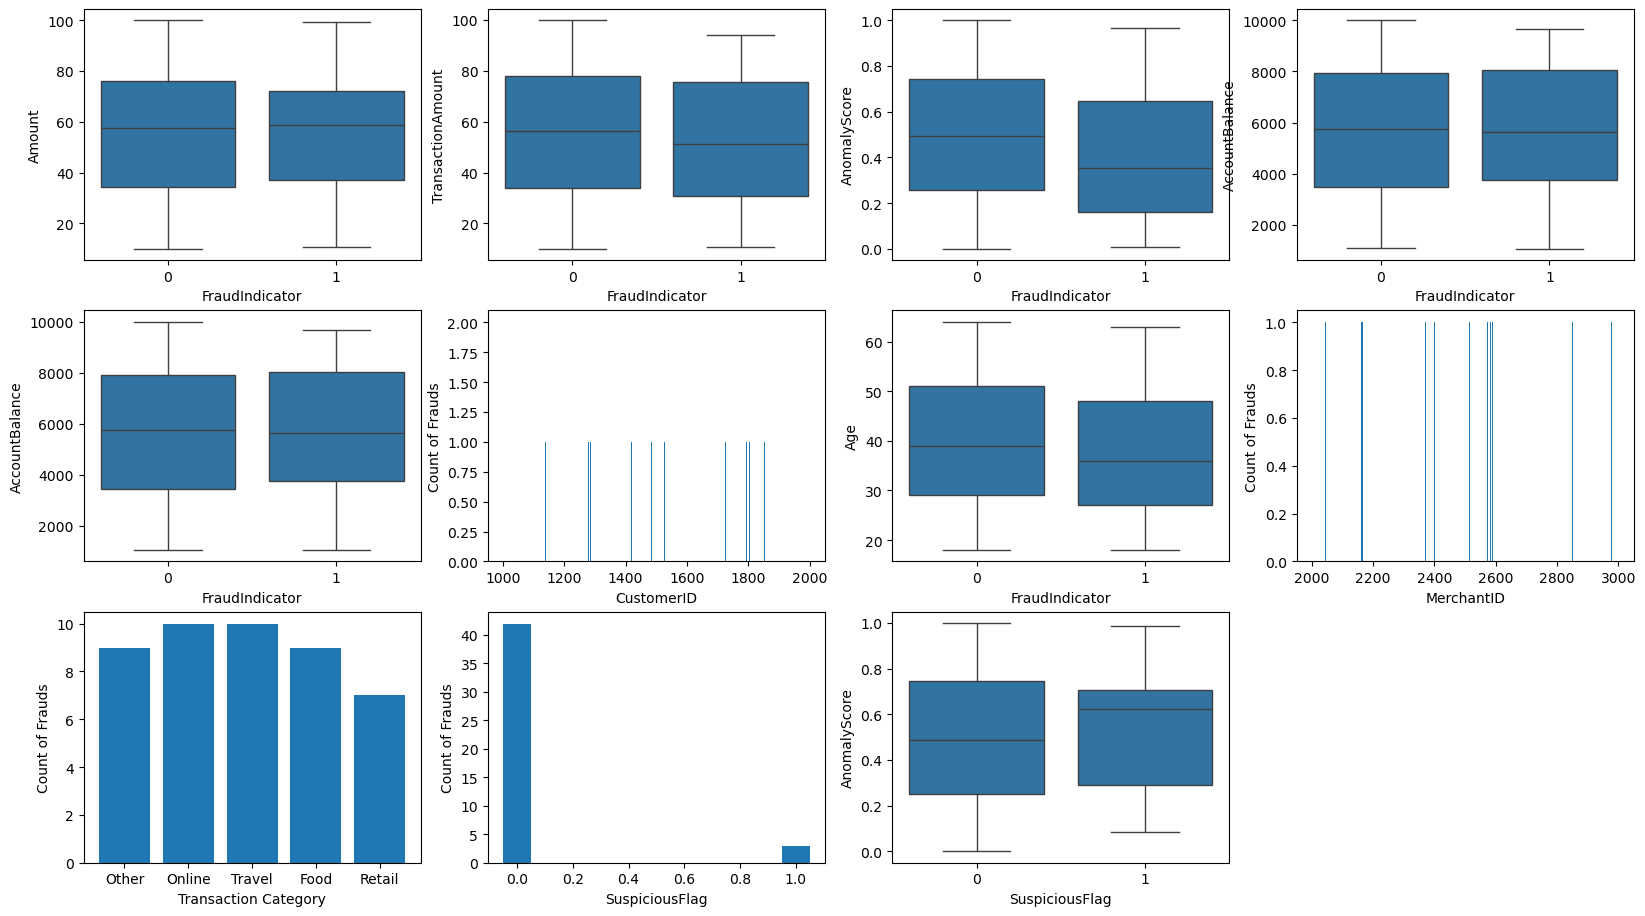

In [88]:
nrow = 4
ncol = 4
index = 1

plt.figure(figsize=(20,15))

plt.subplot(nrow,ncol,index)
sns.boxplot(data=df, x='FraudIndicator', y='Amount')
index += 1

plt.subplot(nrow,ncol,index)
sns.boxplot(data=df, x='FraudIndicator', y='TransactionAmount')
index += 1

plt.subplot(nrow,ncol,index)
sns.boxplot(data=df, x='FraudIndicator', y='AnomalyScore')
index += 1

plt.subplot(nrow,ncol,index)
sns.boxplot(data=df, x='FraudIndicator', y='AccountBalance')
index += 1

plt.subplot(nrow,ncol,index)
sns.boxplot(data=df, x='FraudIndicator', y='AccountBalance')
index += 1

plt.subplot(nrow,ncol,index)
plt.bar(df['CustomerID'].unique(), df.groupby(by='CustomerID')['FraudIndicator'].sum())
plt.xlabel('CustomerID')
plt.ylabel('Count of Frauds')
index += 1

plt.subplot(nrow,ncol,index)
sns.boxplot(data=df, x='FraudIndicator', y='Age')
index += 1

plt.subplot(nrow,ncol,index)
plt.bar(df['MerchantID'].unique(), df.groupby(by='MerchantID')['FraudIndicator'].sum())
plt.xlabel('MerchantID')
plt.ylabel('Count of Frauds')
index += 1

plt.subplot(nrow,ncol,index)
plt.bar(df['Category'].unique(), df.groupby(by='Category')['FraudIndicator'].sum())
plt.xlabel('Transaction Category')
plt.ylabel('Count of Frauds')
index += 1

plt.subplot(nrow,ncol,index)
plt.bar(df['SuspiciousFlag'].unique(), df.groupby(by='SuspiciousFlag')['FraudIndicator'].sum(), width=0.1)
plt.xlabel('SuspiciousFlag')
plt.ylabel('Count of Frauds')
index += 1

plt.subplot(nrow,ncol,index)
sns.boxplot(data=df, x='SuspiciousFlag', y='AnomalyScore')
index += 1

plt.show()

Based on the above, it is observed that:
- there is no apparent distinguishment between fraudulent transaction and normal transaction, which is likely the case in real-world scenario
- Interestingly, fraudulent transactions are likely to have lower anomaly score compared to normal transaction. It is unlikely that the scoring system intends to assign a lower score to fraudulent transactions as transactions with suspicious flag tend to have a higher anamoly score. This may suggest that the scoring system is ineffective at all.
- Fraudulent transactions are likely to be under "Travel", "Online" and "Food" category.

Since the current variables do not seem to be a good predictor, it may be necessary to do some feature engineering to create some new features.

We note that there are two columns indicating the transaction amount: "TransactionAmount" and "Amount". Let's create a correlation map to see whether they are highly correlated. If yes, then they are likely to be representing the same thing and we can drop one of the column to reduce the noise.

In [89]:
df[['TransactionAmount', 'Amount']].corr()

,TransactionAmount,Amount
TransactionAmount,1.000000,-0.002585
Amount,-0.002585,1.000000


It seems that they are not correlated with each other. In this case, it may worth keeping both columns for our model.

## 3. Feature Engineering

### Timestamp

Create extra columns for Month, Weekday, Day and Hour to see if fraud is likely to occur at a particular pattern in time.

In [90]:
df.insert(4, "Month", df['Timestamp'].apply(lambda x: int(dt.strptime(x, "%Y-%m-%d %H:%M:%S").strftime("%m")))) # Get the month from "Timestamp" and show as integer
df.insert(5, "Weekday", df['Timestamp'].apply(lambda x: int(dt.strptime(x, "%Y-%m-%d %H:%M:%S").strftime("%w")))) # Get the weekday from "Timestamp" and show as integer
df.insert(5, "Day", df['Timestamp'].apply(lambda x: int(dt.strptime(x, "%Y-%m-%d %H:%M:%S").strftime("%d")))) # Get day in a month from "Timestamp" and show as integer
df.insert(6, "Hour", df['Timestamp'].apply(lambda x: int(dt.strptime(x, "%Y-%m-%d %H:%M:%S").strftime("%H")))) # Get the hour from "Timestamp" and show as integer
df.head(2)

,TransactionID,Amount,CustomerID,Timestamp,Month,Day,Hour,Weekday,MerchantID,AnomalyScore,...,FraudIndicator,Category,MerchantName,Location,Name,Age,Address,AccountBalance,LastLogin,SuspiciousFlag
0,1,55.530334,1952,2022-01-01 00:00:00,1,1,0,6,2701,0.686699,...,0,Other,Merchant 2701,Location 2701,Customer 1952,50,Address 1952,2869.689912,2024-08-09,0
1,2,12.881180,1027,2022-01-01 01:00:00,1,1,1,6,2070,0.081749,...,0,Online,Merchant 2070,Location 2070,Customer 1027,46,Address 1027,9527.947107,2022-01-27,0


In [91]:
print(f"Date range of data: {df['Timestamp'].min()} - {df['Timestamp'].max()}")

Date range of data: 2022-01-01 00:00:00 - 2022-02-11 15:00:00


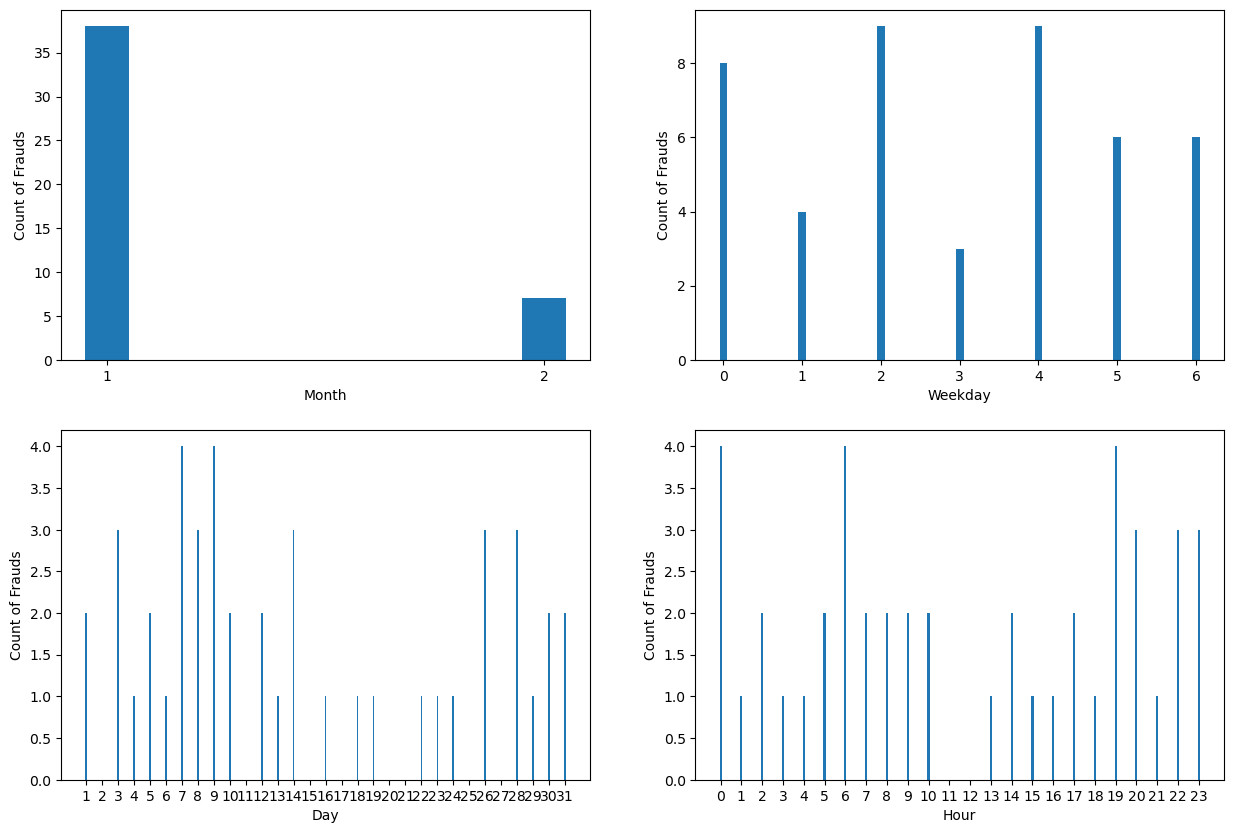

In [92]:
nrow = 2
ncol = 2
index = 1

plt.figure(figsize=(15,10))

for var in ["Month", "Weekday", "Day", "Hour"]:
    plt.subplot(nrow,ncol,index)
    plt.bar(df[var].unique(), df.groupby(by=var)['FraudIndicator'].sum(), width=0.1)
    plt.xticks(np.sort(df[var].unique()))
    plt.xlabel(var)
    plt.ylabel('Count of Frauds')
    index += 1

plt.show()

Based on the above, it is observed that:
- Fraudulent transactions are likely to occur on Sunday, Tuesday and Thursday
- Most fraudulent transactions occur at 12am, 6am and 19pm, whilst there are also more fraudulent transactions during non-office hour (9am-6pm). It is unclear whether it's simply becaues there are more transactions during the non-office hour (regardless of fraudulent or not). In this case, let's create a new indicator variable of office/non-office hour.
- Month and Day may not have much insight as our data only covers January and half of february.


In [93]:
def officehour(hour:int):
    if hour >= 9 and hour <= 18:
        return 1
    else:
        return 0

df['OfficeHour'] = df['Hour'].apply(officehour)
df.head(5)

,TransactionID,Amount,CustomerID,Timestamp,Month,Day,Hour,Weekday,MerchantID,AnomalyScore,...,Category,MerchantName,Location,Name,Age,Address,AccountBalance,LastLogin,SuspiciousFlag,OfficeHour
0,1,55.530334,1952,2022-01-01 00:00:00,1,1,0,6,2701,0.686699,...,Other,Merchant 2701,Location 2701,Customer 1952,50,Address 1952,2869.689912,2024-08-09,0,0
1,2,12.881180,1027,2022-01-01 01:00:00,1,1,1,6,2070,0.081749,...,Online,Merchant 2070,Location 2070,Customer 1027,46,Address 1027,9527.947107,2022-01-27,0,0
2,3,50.176322,1955,2022-01-01 02:00:00,1,1,2,6,2238,0.023857,...,Travel,Merchant 2238,Location 2238,Customer 1955,34,Address 1955,9288.355525,2024-08-12,0,0
3,4,41.634001,1796,2022-01-01 03:00:00,1,1,3,6,2879,0.876994,...,Travel,Merchant 2879,Location 2879,Customer 1796,33,Address 1796,5588.049942,2024-03-06,0,0
4,5,78.122853,1946,2022-01-01 04:00:00,1,1,4,6,2966,0.034059,...,Other,Merchant 2966,Location 2966,Customer 1946,18,Address 1946,7324.785332,2024-08-03,0,0


In [94]:
df.groupby(['OfficeHour','FraudIndicator'])['TransactionID'].count().unstack(fill_value=0)

FraudIndicator,0,1
OfficeHour,,
0,550,33
1,405,12


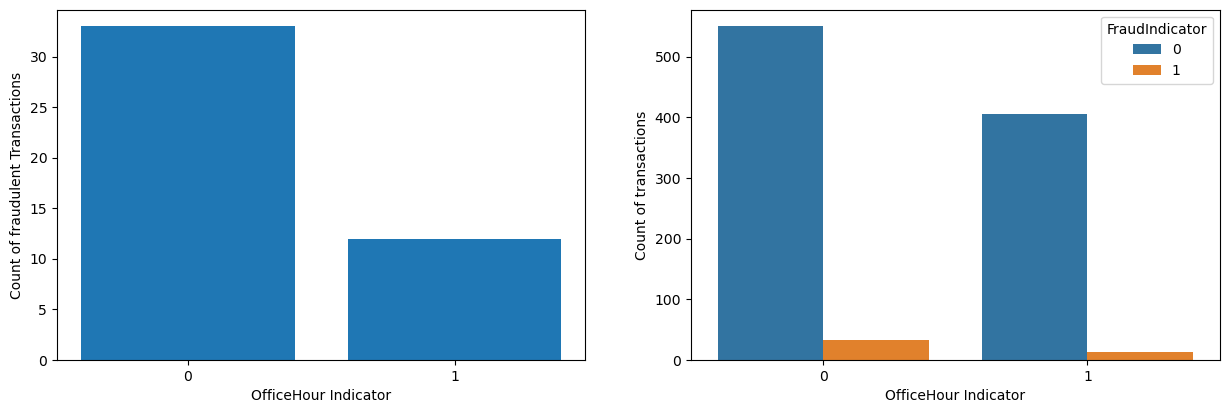

In [95]:
nrow = 2
ncol = 2
index = 1

plt.figure(figsize=(15,10))

plt.subplot(nrow, ncol, index)
plt.bar(x= df['OfficeHour'].unique(), height=df.groupby('OfficeHour')['FraudIndicator'].sum())
plt.xlabel("OfficeHour Indicator")
plt.ylabel("Count of fraudulent Transactions")
plt.xticks([0,1])
index += 1

plt.subplot(nrow, ncol, index)
sns.countplot(data=df, x='OfficeHour', hue='FraudIndicator')
plt.xlabel("OfficeHour Indicator")
plt.ylabel("Count of transactions")
index += 1

plt.show()

### Customer data

Let's define a new column (AmtBalRatio) that represents the ratio of transaction amount to the corresponding customer's account balance.

In [96]:
df['AmtBalRatio'] = df['TransactionAmount'] / df['AccountBalance']
df.head(5)

,TransactionID,Amount,CustomerID,Timestamp,Month,Day,Hour,Weekday,MerchantID,AnomalyScore,...,MerchantName,Location,Name,Age,Address,AccountBalance,LastLogin,SuspiciousFlag,OfficeHour,AmtBalRatio
0,1,55.530334,1952,2022-01-01 00:00:00,1,1,0,6,2701,0.686699,...,Merchant 2701,Location 2701,Customer 1952,50,Address 1952,2869.689912,2024-08-09,0,0,0.027673
1,2,12.881180,1027,2022-01-01 01:00:00,1,1,1,6,2070,0.081749,...,Merchant 2070,Location 2070,Customer 1027,46,Address 1027,9527.947107,2022-01-27,0,0,0.001265
2,3,50.176322,1955,2022-01-01 02:00:00,1,1,2,6,2238,0.023857,...,Merchant 2238,Location 2238,Customer 1955,34,Address 1955,9288.355525,2024-08-12,0,0,0.003586
3,4,41.634001,1796,2022-01-01 03:00:00,1,1,3,6,2879,0.876994,...,Merchant 2879,Location 2879,Customer 1796,33,Address 1796,5588.049942,2024-03-06,0,0,0.008254
4,5,78.122853,1946,2022-01-01 04:00:00,1,1,4,6,2966,0.034059,...,Merchant 2966,Location 2966,Customer 1946,18,Address 1946,7324.785332,2024-08-03,0,0,0.007379


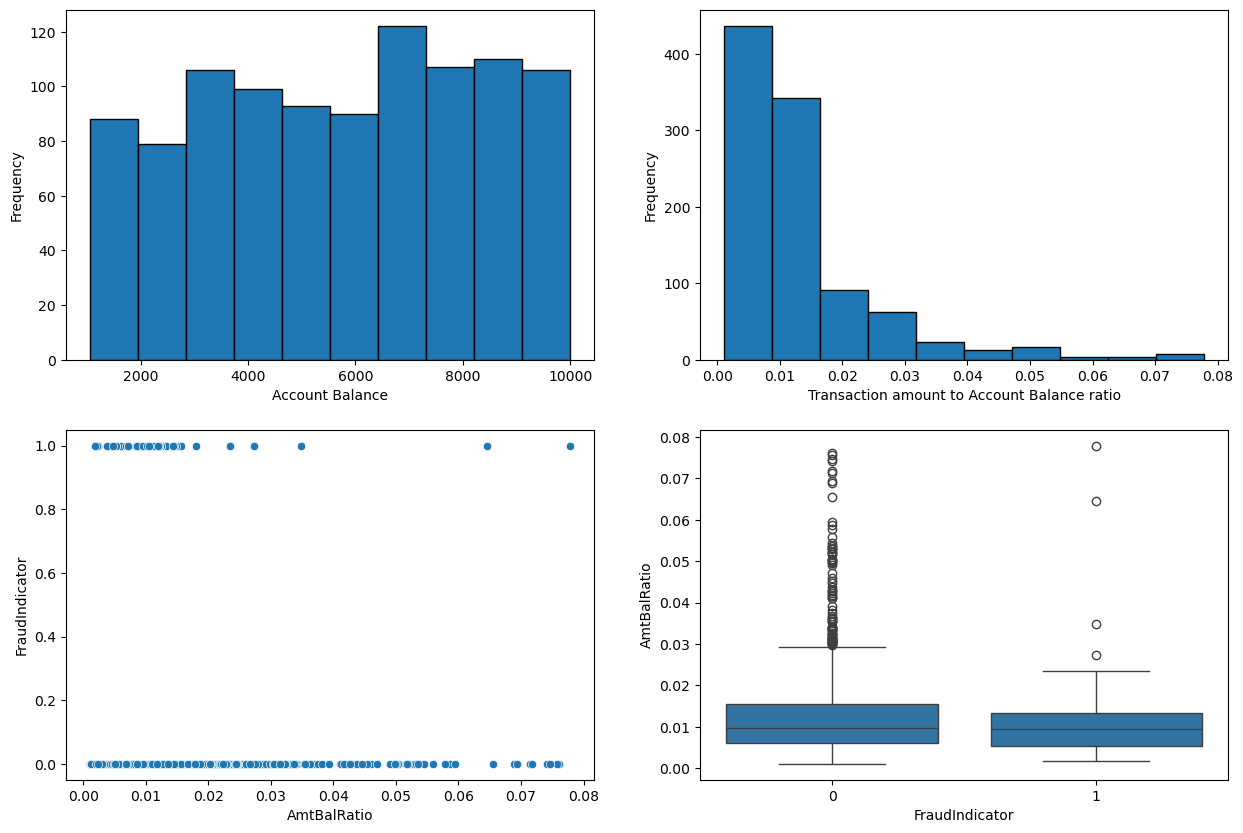

In [97]:
nrow = 2
ncol = 2
index = 1

plt.figure(figsize=(15,10))

plt.subplot(nrow, ncol, index)
plt.hist(df['AccountBalance'], edgecolor='black')
plt.xlabel('Account Balance')
plt.ylabel("Frequency")
index += 1

plt.subplot(nrow, ncol, index)
plt.hist(df['AmtBalRatio'], edgecolor='black')
plt.xlabel('Transaction amount to Account Balance ratio')
plt.ylabel("Frequency")
index += 1

plt.subplot(nrow, ncol, index)
sns.scatterplot(data=df, x='AmtBalRatio', y='FraudIndicator')
index += 1

plt.subplot(nrow, ncol, index)
sns.boxplot(data=df, x='FraudIndicator', y='AmtBalRatio')
index += 1

plt.show()

- Majority of the transactions are within 2% of the customer's account balance.
- The AmtBalRatio of fraudulent transactions are slightly less than normal transactions.

Let's also look at the address of the customer.

In [98]:
df['Address'].unique()

array(['Address 1952', 'Address 1027', 'Address 1955', 'Address 1796',
       'Address 1946', 'Address 1204', 'Address 1311', 'Address 1693',
       'Address 1347', 'Address 1574', 'Address 1424', 'Address 1302',
       'Address 1321', 'Address 1700', 'Address 1463', 'Address 1962',
       'Address 1854', 'Address 1651', 'Address 1715', 'Address 1724',
       'Address 1117', 'Address 1613', 'Address 1643', 'Address 1788',
       'Address 1251', 'Address 1960', 'Address 1187', 'Address 1121',
       'Address 1475', 'Address 1993', 'Address 1030', 'Address 1116',
       'Address 1676', 'Address 1547', 'Address 1527', 'Address 1087',
       'Address 1207', 'Address 1038', 'Address 1800', 'Address 1510',
       'Address 1104', 'Address 2000', 'Address 1644', 'Address 1238',
       'Address 1759', 'Address 1994', 'Address 1752', 'Address 1415',
       'Address 1044', 'Address 1374', 'Address 1345', 'Address 1680',
       'Address 1043', 'Address 1611', 'Address 1704', 'Address 1405',
      

In [99]:
df.groupby('CustomerID')['Address'].nunique().sort_values(ascending=False)

CustomerID
2000    1
1001    1
1003    1
1004    1
1005    1
       ..
1050    1
1051    1
1052    1
1053    1
1054    1
Name: Address, Length: 636, dtype: int64

In real-life scenario, it may be possible that fraudulent transactions is more likely to arise from one location than another, and we can extract the country/city/districts from the address and use those features in our training. 

However, in our case it appears that the addresses of the customers are encoded (potentially for confidentiality reason) and each customer is assigned with a unique address ID. Therefore, address may not give us any indication on fraudulent transactions and hence we will not use it in our training.

Let's also look at the difference between transaction date and last login. 

In [100]:
print(f"Last Login date range: {df['LastLogin'].min()} - {df['LastLogin'].max()}") 

Last Login date range: 2022-01-01 - 2024-09-26


In [101]:
df[['Timestamp', 'LastLogin']].head(20)

,Timestamp,LastLogin
0,2022-01-01 00:00:00,2024-08-09
1,2022-01-01 01:00:00,2022-01-27
2,2022-01-01 02:00:00,2024-08-12
3,2022-01-01 03:00:00,2024-03-06
4,2022-01-01 04:00:00,2024-08-03
5,2022-01-01 05:00:00,2022-07-23
6,2022-01-01 06:00:00,2022-11-07
7,2022-01-01 07:00:00,2023-11-24
8,2022-01-01 08:00:00,2022-12-13
9,2022-01-01 09:00:00,2023-07-28


The Last Login dates for most records are later than the transaction dates, suggesting that the data was collected at a point in time after the actual transactions occurred, whilst `LastLogin` represents the last login date as at the data collection date, instead of the last login date prior to the transaction.

In case where we would like to make immediate prediction as soon as the transaction occurs, `LastLogin` may not give valuable insights because it will just simply be same as the transaction date. As a result, we will not include this feature in our model.

## 4. Feature Selection and data preprocessing

Based on the above explanatory data analysis, let's select the following features for training our model:
- Amount
- TransactionAmount
- Weekday
- OfficeHour
- AmtBalRatio
- AnomalyScore
- SuspiciousFlag
- Category

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TransactionID      1000 non-null   int64  
 1   Amount             1000 non-null   float64
 2   CustomerID         1000 non-null   int64  
 3   Timestamp          1000 non-null   object 
 4   Month              1000 non-null   int64  
 5   Day                1000 non-null   int64  
 6   Hour               1000 non-null   int64  
 7   Weekday            1000 non-null   int64  
 8   MerchantID         1000 non-null   int64  
 9   AnomalyScore       1000 non-null   float64
 10  TransactionAmount  1000 non-null   float64
 11  FraudIndicator     1000 non-null   int64  
 12  Category           1000 non-null   object 
 13  MerchantName       1000 non-null   object 
 14  Location           1000 non-null   object 
 15  Name               1000 non-null   object 
 16  Age                1000 n

In [103]:
X = df[['Amount', 'TransactionAmount', 'Weekday', 'OfficeHour', 'AmtBalRatio', 'AnomalyScore', 'SuspiciousFlag', 'Category']].copy(deep=True)
y = df['FraudIndicator'].copy(deep=True)

Before we can train our model, we need to first encode our categorical feature into binary indicator. Since logistic regression will be affected by multi-collinearity, we should drop one of the category. In this case, we will create two sets of data: "lr" data for logistic regression and "tr" for tree models.

In [104]:
X_lr = pd.get_dummies(X, columns=['Category'], drop_first=True)
X_tr = pd.get_dummies(X, columns=['Category'], drop_first=False)

In addition, we should also normalize our numerical data.

In [105]:
scaler = StandardScaler()
numerical_features = ['Amount', 'TransactionAmount']

for feature in numerical_features:
    X_lr[feature] = scaler.fit_transform(X_lr[[feature]])
    X_tr[feature] = scaler.fit_transform(X_tr[[feature]])

print(X_lr.describe())
print(X_tr.describe())

             Amount  TransactionAmount      Weekday  OfficeHour  AmtBalRatio  \
count  1.000000e+03       1.000000e+03  1000.000000  1000.00000  1000.000000   
mean   1.598721e-16       3.907985e-17     2.984000     0.41700     0.013164   
std    1.000500e+00       1.000500e+00     2.000937     0.49331     0.011948   
min   -1.811296e+00      -1.755943e+00     0.000000     0.00000     0.001085   
25%   -8.337589e-01      -8.427235e-01     1.000000     0.00000     0.006013   
50%    9.775030e-02       4.006338e-03     3.000000     0.00000     0.009758   
75%    8.166447e-01       8.334011e-01     5.000000     1.00000     0.015339   
max    1.775563e+00       1.684416e+00     6.000000     1.00000     0.077885   

       AnomalyScore  SuspiciousFlag  
count   1000.000000     1000.000000  
mean       0.492282        0.025000  
std        0.288423        0.156203  
min        0.000234        0.000000  
25%        0.251802        0.000000  
50%        0.490242        0.000000  
75%        0.

In [106]:
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(X_lr, y, test_size=0.2, random_state=1207, stratify=y)
X_tr_train, X_tr_test, y_tr_train, y_tr_test = train_test_split(X_tr, y, test_size=0.2, random_state=1207, stratify=y)

len(X_lr_train), len(X_lr_test), len(y_lr_train), len(y_lr_test), len(X_tr_train), len(X_tr_test), len(y_tr_train), len(y_tr_test)

(800, 200, 800, 200, 800, 200, 800, 200)

Since our data is highly imbalanced, we need to use SMOTE to oversample the minority class in our training data. Note that we should never use such technique on our testing data because the testing data is supposed to validate our performance under a real-life situation.

In [107]:
sm = SMOTE(sampling_strategy=0.5, random_state=1207)
X_lr_train, y_lr_train = sm.fit_resample(X=X_lr_train, y=y_lr_train)
X_tr_train, y_tr_train = sm.fit_resample(X=X_tr_train, y=y_tr_train)

len(X_lr_train), len(y_lr_train), len(X_tr_train), len(y_tr_train)

(1146, 1146, 1146, 1146)

In [108]:
print(y_lr_train.value_counts())
print(y_tr_train.value_counts())

FraudIndicator
0    764
1    382
Name: count, dtype: int64
FraudIndicator
0    764
1    382
Name: count, dtype: int64


## 5. Model Training

Let's define a function for model revaluation and storing the result.

In [109]:
def make_results(model_name:str, y_true, y_pred, y_pred_proba):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true=y_true, y_score=[y_pred_proba[x][1] for x in range(len(y_pred_proba))])
    result = pd.DataFrame({'Model': [model_name],
                        'F1': [round(f1,4)],
                        'Recall': [round(recall,4)],
                        'Precision': [round(precision,4)],
                        'Accuracy': [round(accuracy,4)],
                        'AUC': [round(auc, 4)]})
    return result

def cv_make_results(model_name: str, model_object):
    cv_results = pd.DataFrame(model_object.cv_results_)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(),:]
    
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    accuracy = best_estimator_results.mean_test_accuracy
    precision = best_estimator_results.mean_test_precision

    result = pd.DataFrame({'Model': [model_name],
                          'F1': [round(f1,4)],
                          'Recall': [round(recall,4)],
                          'Precision': [round(precision,4)],
                          'Accuracy': [round(accuracy,4)]})
    return result

def update_result_table(existing_result_table: pd.DataFrame, new_result_table: pd.DataFrame):
    return pd.concat([existing_result_table, new_result_table], axis=0, ignore_index=True)

### Logistics Regression

In [110]:
lr = LogisticRegression(random_state=1207)
lr = lr.fit(X_lr_train, y_lr_train)
y_lr_pred = lr.predict(X_lr_test).tolist()
y_lr_pred_proba = lr.predict_proba(X_lr_test).tolist()

lr_result = make_results(model_name="Logistic Regression", y_true=y_lr_test, y_pred=y_lr_pred, y_pred_proba=y_lr_pred_proba)
lr_result

,Model,F1,Recall,Precision,Accuracy,AUC
0,Logistic Regression,0.0,0.0,0.0,0.915,0.4171


### Decision Tree

In order to perform hyperparameter tuning, we will use GridSearch cross-validation technique to look for the optimal combination for the tree model. Bear in mind that our objective is to detect fraudulent transactions which are considerably rare in reality, and the consequence of mis-classifying a normal transcation as fraudulent transaction is much smaller than mis-classifying a fraudulent transaction as normal transaction. Therefore, our scoring metric should be focused on recall.

In [111]:
# Define the dictionary of hyperparameter values
tree_parameter = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50],
                  'min_samples_leaf':[2,5,10,20,50]}

# Define the metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']

decision_tree = DecisionTreeClassifier(random_state=1207)
dt_cv = GridSearchCV(decision_tree,
                     tree_parameter,
                     scoring=scoring,
                     cv=5, # The number of cross-validation folds
                     refit='recall').fit(X_tr_train, y_tr_train) # The scoring metric that you want GridSearch to use when it selects the "best" model. The reason it's called refit is because once the algorithm finds the combination of hyperparameters that results in the best average score across all validation folds, it will then refit this model to all of the training data. Remember, up until now, with a 5-fold cross-validation, the model has only ever been fit on 80% (4/5) of the training data, because the remaining 20% was held out as a validation fold.)
print(f"Best model estimator: {dt_cv.best_estimator_}")
print(f"Best Avg. Validation Score: {dt_cv.best_score_:.4f}%")

y_tr_pred = dt_cv.predict(X_tr_test)
y_tr_pred_proba = dt_cv.predict_proba(X_tr_test)
decision_tree_result = make_results(model_name="Decision Tree", y_true = y_tr_test, y_pred = y_tr_pred, y_pred_proba=y_tr_pred_proba)
decision_tree_result

Best model estimator: DecisionTreeClassifier(max_depth=11, min_samples_leaf=2, random_state=1207)
Best Avg. Validation Score: 0.8198%


c:\Users\Louis\.conda\envs\fraud-detection\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


,Model,F1,Recall,Precision,Accuracy,AUC
0,Decision Tree,0.25,0.4444,0.1739,0.88,0.6521


In [112]:
result = update_result_table(lr_result, decision_tree_result)
result

,Model,F1,Recall,Precision,Accuracy,AUC
0,Logistic Regression,0.00,0.0000,0.0000,0.915,0.4171
1,Decision Tree,0.25,0.4444,0.1739,0.880,0.6521


### Random Forest

Similar to decision tree, GridSearch cross-validation technique will be used to look for the optimal combination of the random forest model.

In [113]:
import warnings

warnings.filterwarnings(action='ignore')

In [114]:
rf_params = {'max_depth': [2,3,4,5,None], # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
             'min_samples_leaf': [1,2,3], # The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches.
             'min_samples_split': [2,3,4], # The minimum number of samples required to split an internal node
             'max_features': [2,3,4], # The number of features to consider when looking for the best split
             'n_estimators': [75, 100, 125, 150]} # The number of trees in the forest.

# Define the metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']

rf = RandomForestClassifier(random_state=1207)
rf_cv = GridSearchCV(rf,
                     rf_params,
                     scoring=scoring,
                     cv=5, # The number of cross-validation folds
                     refit='recall').fit(X_tr_train, y_tr_train) 

print(f"Best model estimator: {rf_cv.best_estimator_}")
print(f"Best Avg. Validation Score: {rf_cv.best_score_:.4f}%")

y_tr_pred = rf_cv.predict(X_tr_test)
y_tr_pred_proba = rf_cv.predict_proba(X_tr_test)
rf_result = make_results(model_name="Random Forest", y_true = y_tr_test, y_pred = y_tr_pred, y_pred_proba=y_tr_pred_proba)
rf_result


Best model estimator: RandomForestClassifier(max_features=2, min_samples_split=3, n_estimators=150,
                       random_state=1207)
Best Avg. Validation Score: 0.9297%


,Model,F1,Recall,Precision,Accuracy,AUC
0,Random Forest,0.1818,0.1111,0.5,0.955,0.4316


In [115]:
result = update_result_table(result, rf_result)
result

,Model,F1,Recall,Precision,Accuracy,AUC
0,Logistic Regression,0.0000,0.0000,0.0000,0.915,0.4171
1,Decision Tree,0.2500,0.4444,0.1739,0.880,0.6521
2,Random Forest,0.1818,0.1111,0.5000,0.955,0.4316


### XGBoost

In [116]:
xgb_params = {'max_depth': [4,5,6,7,8], # Specifies how many levels your base learner trees can have. 
             'min_child_weight': [1,2,3,4,5], # Controls threshold below which a node becomes a leaf, based on the combined weight of the samples it contains.  For regression models, this value is functionally equivalent to a number of samples. For the binary classification objective, the weight of a sample in a node is dependent on its probability of response as calculated by that tree. The weight of the sample decreases the more certain the model is (i.e., the closer the probability of response is to 0 or 1).
             'learning_rate': [0.1,0.2,0.3], # Controls how much importance is given to each consecutive base learner in the ensemble’s final prediction. Also known as eta or shrinkage. 
             'n_estimators': [75, 100, 125]} # Specifies the number of boosting rounds (i.e., the number of trees your model will build in its ensemble)

xgb = XGBClassifier(objective='binary:logistic', random_state=1207)

scoring = ['accuracy', 'precision', 'recall', 'f1']

xgb_cv = GridSearchCV(xgb, xgb_params, scoring=scoring, cv=5, refit='recall').fit(X_tr_train, y_tr_train)

print(f"Best model estimator: {xgb_cv.best_estimator_}")
print(f"Best Avg. Validation Score: {xgb_cv.best_score_:.4f}%")

y_tr_pred = xgb_cv.predict(X_tr_test)
y_tr_pred_proba = xgb_cv.predict_proba(X_tr_test)
xgb_result = make_results(model_name="XGBoost", y_true = y_tr_test, y_pred = y_tr_pred, y_pred_proba = y_tr_pred_proba)
xgb_result

Best model estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=125, n_jobs=None,
              num_parallel_tree=None, random_state=1207, ...)
Best Avg. Validation Score: 0.9350%


,Model,F1,Recall,Precision,Accuracy,AUC
0,XGBoost,0.1333,0.1111,0.1667,0.935,0.5608


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

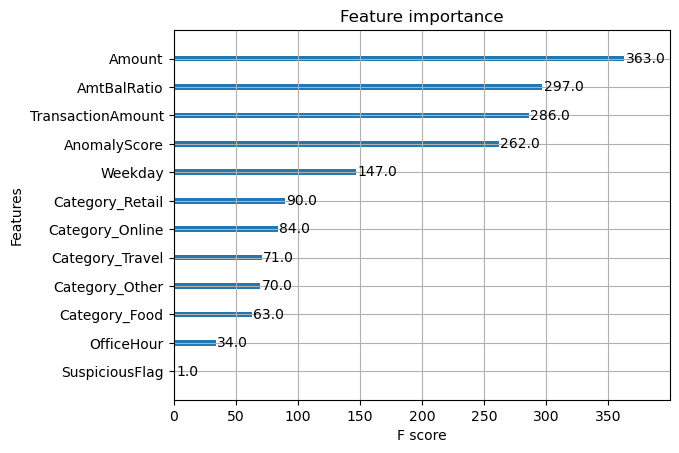

In [117]:
plot_importance(xgb_cv.best_estimator_)

In [118]:
result = update_result_table(result, xgb_result)
result

,Model,F1,Recall,Precision,Accuracy,AUC
0,Logistic Regression,0.0000,0.0000,0.0000,0.915,0.4171
1,Decision Tree,0.2500,0.4444,0.1739,0.880,0.6521
2,Random Forest,0.1818,0.1111,0.5000,0.955,0.4316
3,XGBoost,0.1333,0.1111,0.1667,0.935,0.5608


## 6. Model Evaluation

Based on the testing, it appears that our decision tree model has the highest recall score, hence it is regarded as our best performing model so far. Now, we can plot the decision tree and try to interpret the result.

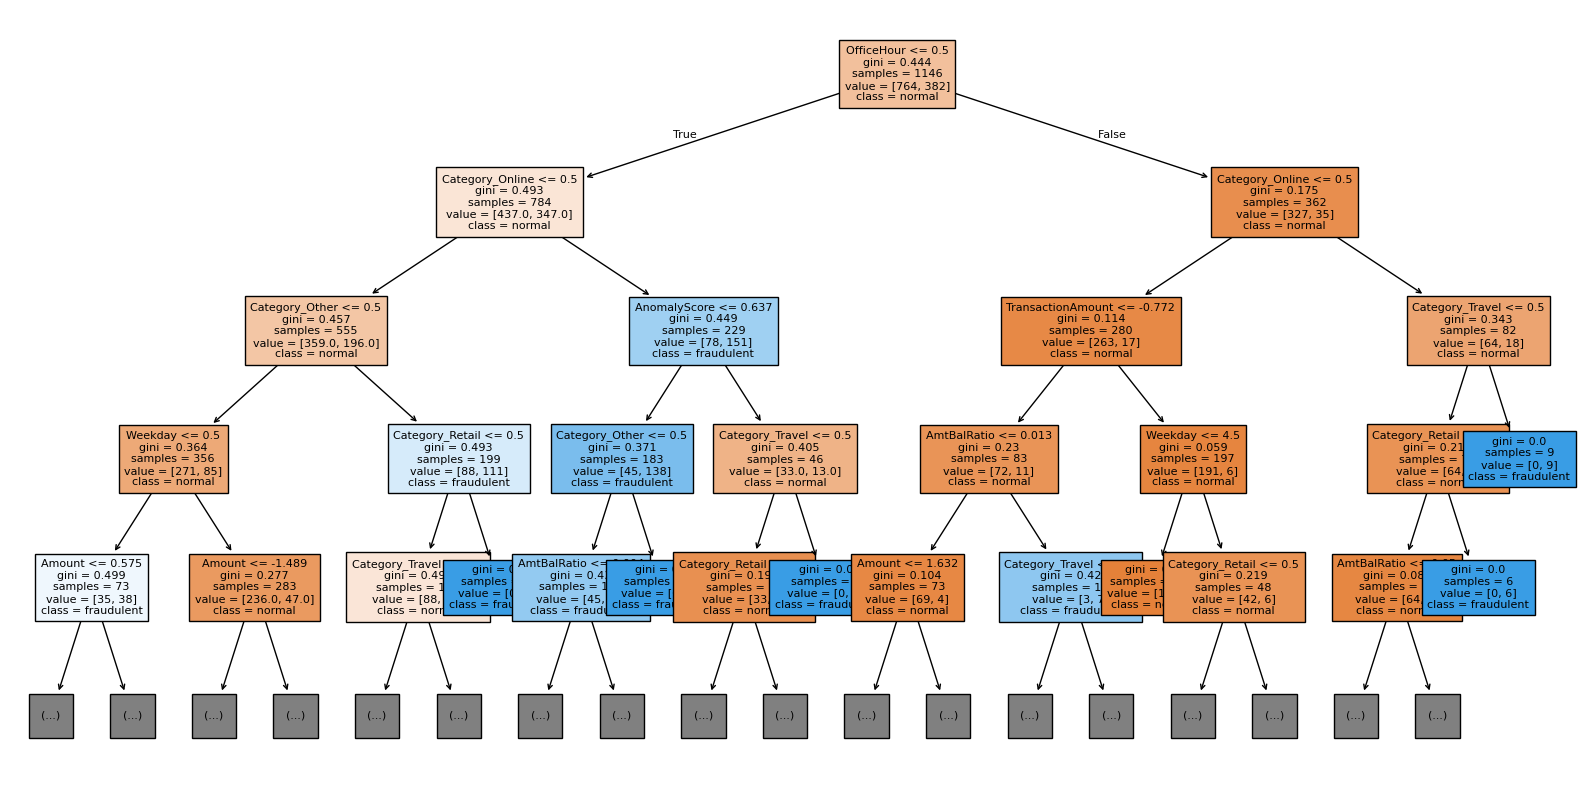

In [119]:
plt.figure(figsize=(20,10))
plot_tree(dt_cv.best_estimator_, max_depth=4, fontsize=8, feature_names=X_tr_train.columns, class_names={0:'normal', 1:'fraudulent'}, filled=True)
plt.show()

As observed during explanatory data analysis, it appears that office hour appears to be the first decision factor, followed by transaction category (whether it is an online/travel transaction), transaction amount and Anomaly score.

In [120]:
feature_importance = sorted(list(zip(dt_cv.best_estimator_.feature_names_in_,dt_cv.best_estimator_.feature_importances_.tolist())), key=lambda x: x[1], reverse=True)
feature_importance

[('Amount', 0.1384003612498369),
 ('OfficeHour', 0.12888639304173805),
 ('AmtBalRatio', 0.11852143423034814),
 ('Category_Travel', 0.11826490901504134),
 ('Category_Retail', 0.10982816096000932),
 ('AnomalyScore', 0.09233930549618687),
 ('Category_Online', 0.0730783913737289),
 ('Category_Other', 0.07098887417973092),
 ('TransactionAmount', 0.05742035545131399),
 ('Weekday', 0.04940640276100141),
 ('Category_Food', 0.032314832357819595),
 ('SuspiciousFlag', 0.010550579883244461)]

The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.

Based on the above, the most important factors are "Amount", "OfficeHour", "AmtBalRatio", "Category_Travel" and "Category_Retail".

## 7. Conclusion

In this project, we explored the use of various machine learning models for the task of fraud detection. We trained and compared the performance of four different classification models: Logistic Regression, Decision Tree, Random Forest, and XGBoost.

The key findings from our analysis are:
- **Decision Tree Classifier Outperforms Other Models**: Among the four models evaluated, the Decision Tree Classifier demonstrated the best performance in terms of the recall score, which is a critical metric for fraud detection applications.
- **Trade-off Between Recall and other metrics**: While the Decision Tree model demonstrated the highest recall score, its precision score was relatively lower compared to the other models. This suggests a trade-off between maximizing the detection of fraudulent transactions (recall) and minimizing the number of false positives (precision). Depending on the specific requirements and priorities of the fraud detection system, the model selection and thresholds may need to be adjusted to strike the right balance between these two metrics.
- **Limited Customer Data Attributes**: The dataset used in this project had customer data that was encoded or anonymized potentially due to the reason that the data may be synthetically generated. As a result, many important features related to the customers were not included in the analysis. In a real-life fraud detection system, having access to comprehensive customer information, such as demographic details, residential location, purchase history, and behavioral patterns, could provide valuable insights and further enhance the model's predictive capabilities. 